# Analysis of the human DLPFC data collected using 10X Visium

For a more detailed function and usage description please refer to the python notebook entitled "Merfish_analysis.ipynb".

## Data description

The human DLPFC data has 13783 genes and 3639 cells/spots after standard quality control. 

## Loading the package and the data

We import the module SMASH and read the gene expression data (as, 'Gene') and the spatial co-ordinates (as, 'Cords'). In this example, the dataframes were stored in a list as a pickled object and compressed using blosc module for efficient storage purposes.

In [1]:
import os
path = "/Users/sealso/Documents/GitHub/SMASH-package"
os.chdir(path + "/SMASH")

import SMASH 
import pickle
import blosc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2_unweighted
from statsmodels.stats.multitest import multipletests
pd.set_option('display.float_format', '{:.2g}'.format)


with open(path + "/Data/Visium.pickle", "rb") as fp:  
 compressed_pickle = fp.read()

depressed_pickle = blosc.decompress(compressed_pickle)
df = pickle.loads(depressed_pickle)

Gene = df[0]; Cords = df[1];

## Previewing the loaded data

We preview the first few rows of both the dataframes. Notice that the row-names of the two dataframes are matching which implies that the cells/spots are in the same order in both the dataframes.

In [2]:
Gene.head()

x  AL669831.5  NOC2L  KLHL17  HES4  ISG15  AGRN  C1orf159  TNFRSF18  TNFRSF4  \
0           0      0       0     1      0     1         1         0        0   
1           0      0       0     0      0     2         1         0        0   
2           0      1       0     0      0     0         0         0        0   
3           0      0       0     0      0     0         0         0        0   
4           0      2       0     0      1     1         0         0        0   

x  SDF4  ...  MCM3AP  YBEY  PCNT  DIP2A  S100B  PRMT2  AC145212.1  AL592183.1  \
0     1  ...       0     0     2      0      0      1           0           0   
1     0  ...       0     0     0      0      0      0           0           0   
2     0  ...       0     0     0      0     12      1           0           0   
3     1  ...       0     0     0      0      3      0           0           0   
4     0  ...       0     0     0      0      2      2           0           0   

x  AC007325.4  AC007325.2  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           1           0  

[5 rows x 13783 columns]

In [3]:
Cords = Cords.set_axis(["X", "Y"], axis = 1) 
Cords.head()

X     Y
0  9791  8468
1  5769  2807
2  4068  9505
3  9271  4151
4  3393  7583

## Running SMASH

Next, we run the function SMASH with these two dataframes as arguments.

In [4]:
Run_method = SMASH.SMASH(Gene, Cords)

Starting Mean Tests!
Finished Mean Tests!
Starting Covariance Tests!


100%|███████████████████████████████████████████| 10/10 [00:33<00:00,  3.32s/it]


Finished Covariance Tests!


## Extracting SMASH p-values

Next, we extract the dataframe with the SMASH p-values and view first its first few rows. 

In [5]:
SMASH_pvals = Run_method['SMASH']
SMASH_pvals.head() 

Gene   p-val
0  AL669831.5    0.29
1       NOC2L 3.3e-36
2      KLHL17 0.00013
3        HES4 1.6e-52
4       ISG15 1.9e-35

## Benjamini/Yukateli p-value correction for FWER control

We adjust the p-values using Benjamini/Yukateli procedure to control the family wise error rate (FWER) at 0.05.

In [6]:
SMASH_pvals['Adjusted p-val'] = multipletests(SMASH_pvals['p-val'], alpha=0.05, method='fdr_by')[1]
SMASH_pvals.head()

Gene   p-val Adjusted p-val
0  AL669831.5    0.29              1
1       NOC2L 3.3e-36        1.3e-34
2      KLHL17 0.00013         0.0019
3        HES4 1.6e-52        8.7e-51
4       ISG15 1.9e-35        7.4e-34

## Total number of detected SVGs 

We check how many genes are detcted to be SVGs at FWER = 0.05, and extract their names. 

In [7]:
SVGS_SMASH = SMASH_pvals[SMASH_pvals['Adjusted p-val'] < 0.05]
print(SVGS_SMASH)
print({'# detected SVGs ': SVGS_SMASH.shape[0]})

             Gene   p-val Adjusted p-val
1           NOC2L 3.3e-36        1.3e-34
2          KLHL17 0.00013         0.0019
3            HES4 1.6e-52        8.7e-51
4           ISG15 1.9e-35        7.4e-34
5            AGRN 2.4e-53        1.3e-51
...           ...     ...            ...
13776       DIP2A 7.3e-15        1.6e-13
13777       S100B       0              0
13778       PRMT2 2.3e-42          1e-40
13781  AC007325.4 8.5e-51        4.5e-49
13782  AC007325.2  0.0018          0.024

[10666 rows x 3 columns]
{'# detected SVGs ': 10666}


## Visualize the spatial expression of particular SVGs

We display the relative expression of two cortical layer-associated SVGs: MOBP, SNAP25 and two blood and immune-related SVG: HBB, IGKC, in different cells/spots.

{'MOBP p-value ': array([0.0], dtype=object)}


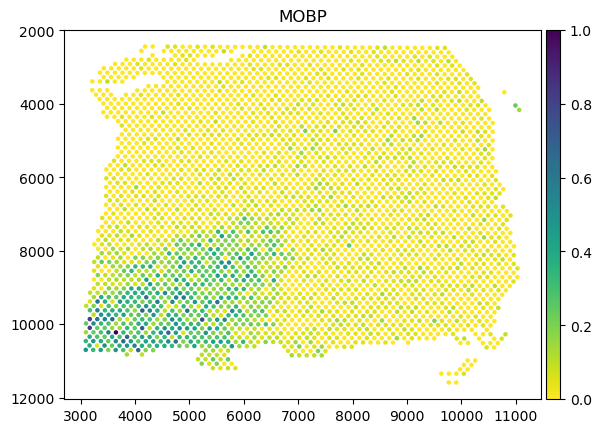

In [36]:
Gene_name = 'MOBP'
Data = pd.concat([Cords, Gene[Gene_name]], axis = 1) # row-names must match
adj_pval = SMASH_pvals[SMASH_pvals['Gene'] == Gene_name]['Adjusted p-val']
print({Gene_name + ' p-value ': adj_pval.values}) # Printing the adjusted p-value of the SVG
SMASH.Expression_plot(Data, Gene_name, s = 5, cmap = 'viridis_r') # Displaying the expression plot of the SVG

{'SNAP25 p-value ': array([0.0], dtype=object)}


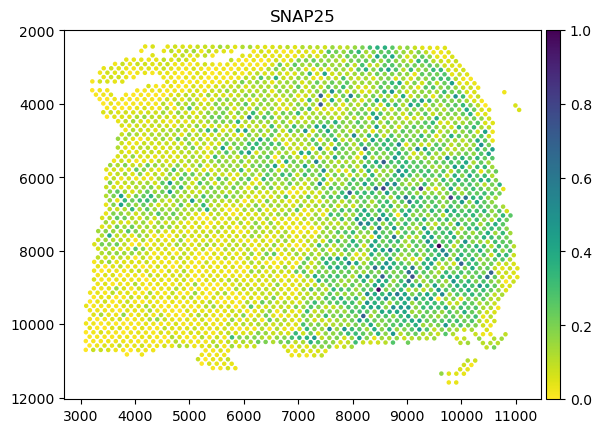

In [37]:
Gene_name = 'SNAP25'
Data = pd.concat([Cords, Gene[Gene_name]], axis = 1) 
adj_pval = SMASH_pvals[SMASH_pvals['Gene'] == Gene_name]['Adjusted p-val']
print({Gene_name + ' p-value ': adj_pval.values}) # Printing the adjusted p-value of the SVG
SMASH.Expression_plot(Data, Gene_name, s = 5, cmap = 'viridis_r') # Displaying the expression plot of the SVG

{'HBB p-value ': array([2.920816523708531e-134], dtype=object)}


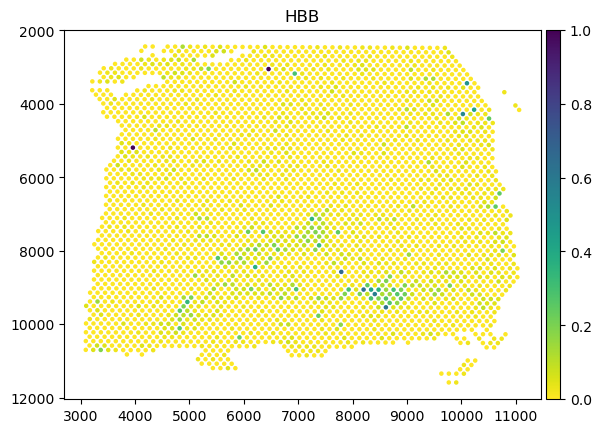

In [38]:
Gene_name = 'HBB'
Data = pd.concat([Cords, Gene[Gene_name]], axis = 1) 
adj_pval = SMASH_pvals[SMASH_pvals['Gene'] == Gene_name]['Adjusted p-val']
print({Gene_name + ' p-value ': adj_pval.values}) # Printing the adjusted p-value of the SVG
SMASH.Expression_plot(Data, Gene_name, s = 5, cmap = 'viridis_r') # Displaying the expression plot of the SVG

{'IGKC p-value ': array([1.3989939463626716e-193], dtype=object)}


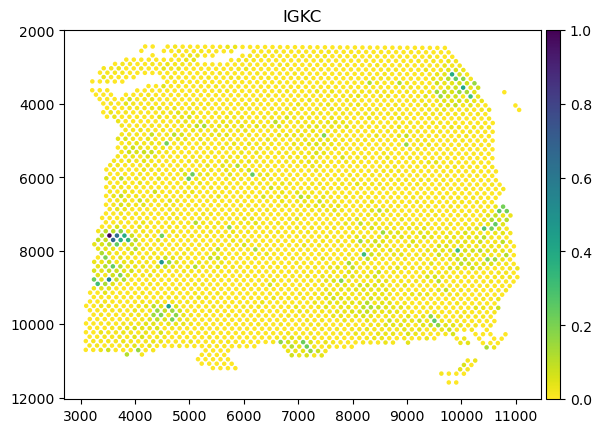

In [39]:
Gene_name = 'IGKC'
Data = pd.concat([Cords, Gene[Gene_name]], axis = 1) 
adj_pval = SMASH_pvals[SMASH_pvals['Gene'] == Gene_name]['Adjusted p-val']
print({Gene_name + ' p-value ': adj_pval.values}) # Printing the adjusted p-value of the SVG
SMASH.Expression_plot(Data, Gene_name, s = 5, cmap = 'viridis_r') # Displaying the expression plot of the SVG

## Overlap between the detected SVGs by SMASH and SPARK-X

We investigate how many genes were detected to be spatially variable by both the methods SMASH and SPARK-X. 

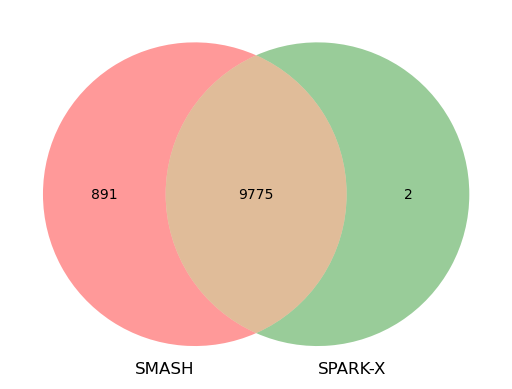

In [8]:
SPARKX_pvals = Run_method['SPARK-X']
SPARKX_pvals['Adjusted p-val'] = multipletests(SPARKX_pvals['p-val'], alpha=0.01, method='fdr_by')[1]
SVGS_SPARKX = SPARKX_pvals[SPARKX_pvals['Adjusted p-val'] < 0.01]
intersection_length = len(np.intersect1d(SVGS_SMASH['Gene'].values, SVGS_SPARKX['Gene'].values))
SMASH_unique_length = len(SVGS_SMASH['Gene']) - intersection_length
SPARKX_unique_length = len(SVGS_SPARKX['Gene']) - intersection_length
venn2_unweighted(subsets = (SMASH_unique_length, SPARKX_unique_length, 
                            intersection_length), set_labels = ('SMASH', 'SPARK-X'))
plt.show()